In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Datasets from Local

Workaround by keeping data files locally and referencing them outside of the jupyter noteboook

In [4]:
weather_train = pd.read_csv('/Users/danielkearney-spaw/Desktop/data_files/weather_train.csv')
meter_train = pd.read_csv('/Users/danielkearney-spaw/Desktop/data_files/train.csv')

weather_test = pd.read_csv('/Users/danielkearney-spaw/Desktop/data_files/weather_test.csv')
meter_test = pd.read_csv('/Users/danielkearney-spaw/Desktop/data_files/test.csv')

building = pd.read_csv('/Users/danielkearney-spaw/Desktop/data_files/building_metadata.csv')

sample_file = pd.read_csv('/Users/danielkearney-spaw/Desktop/data_files/sample_submission.csv')

# Merge Data

In [5]:
train = meter_train.merge(building, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')

test = meter_test.merge(building, on='building_id', how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [6]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [7]:
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])

### EDA

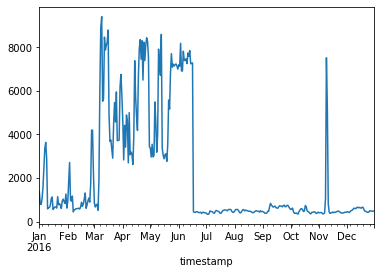

In [8]:
train.set_index('timestamp').resample('D')['meter_reading'].mean().plot()

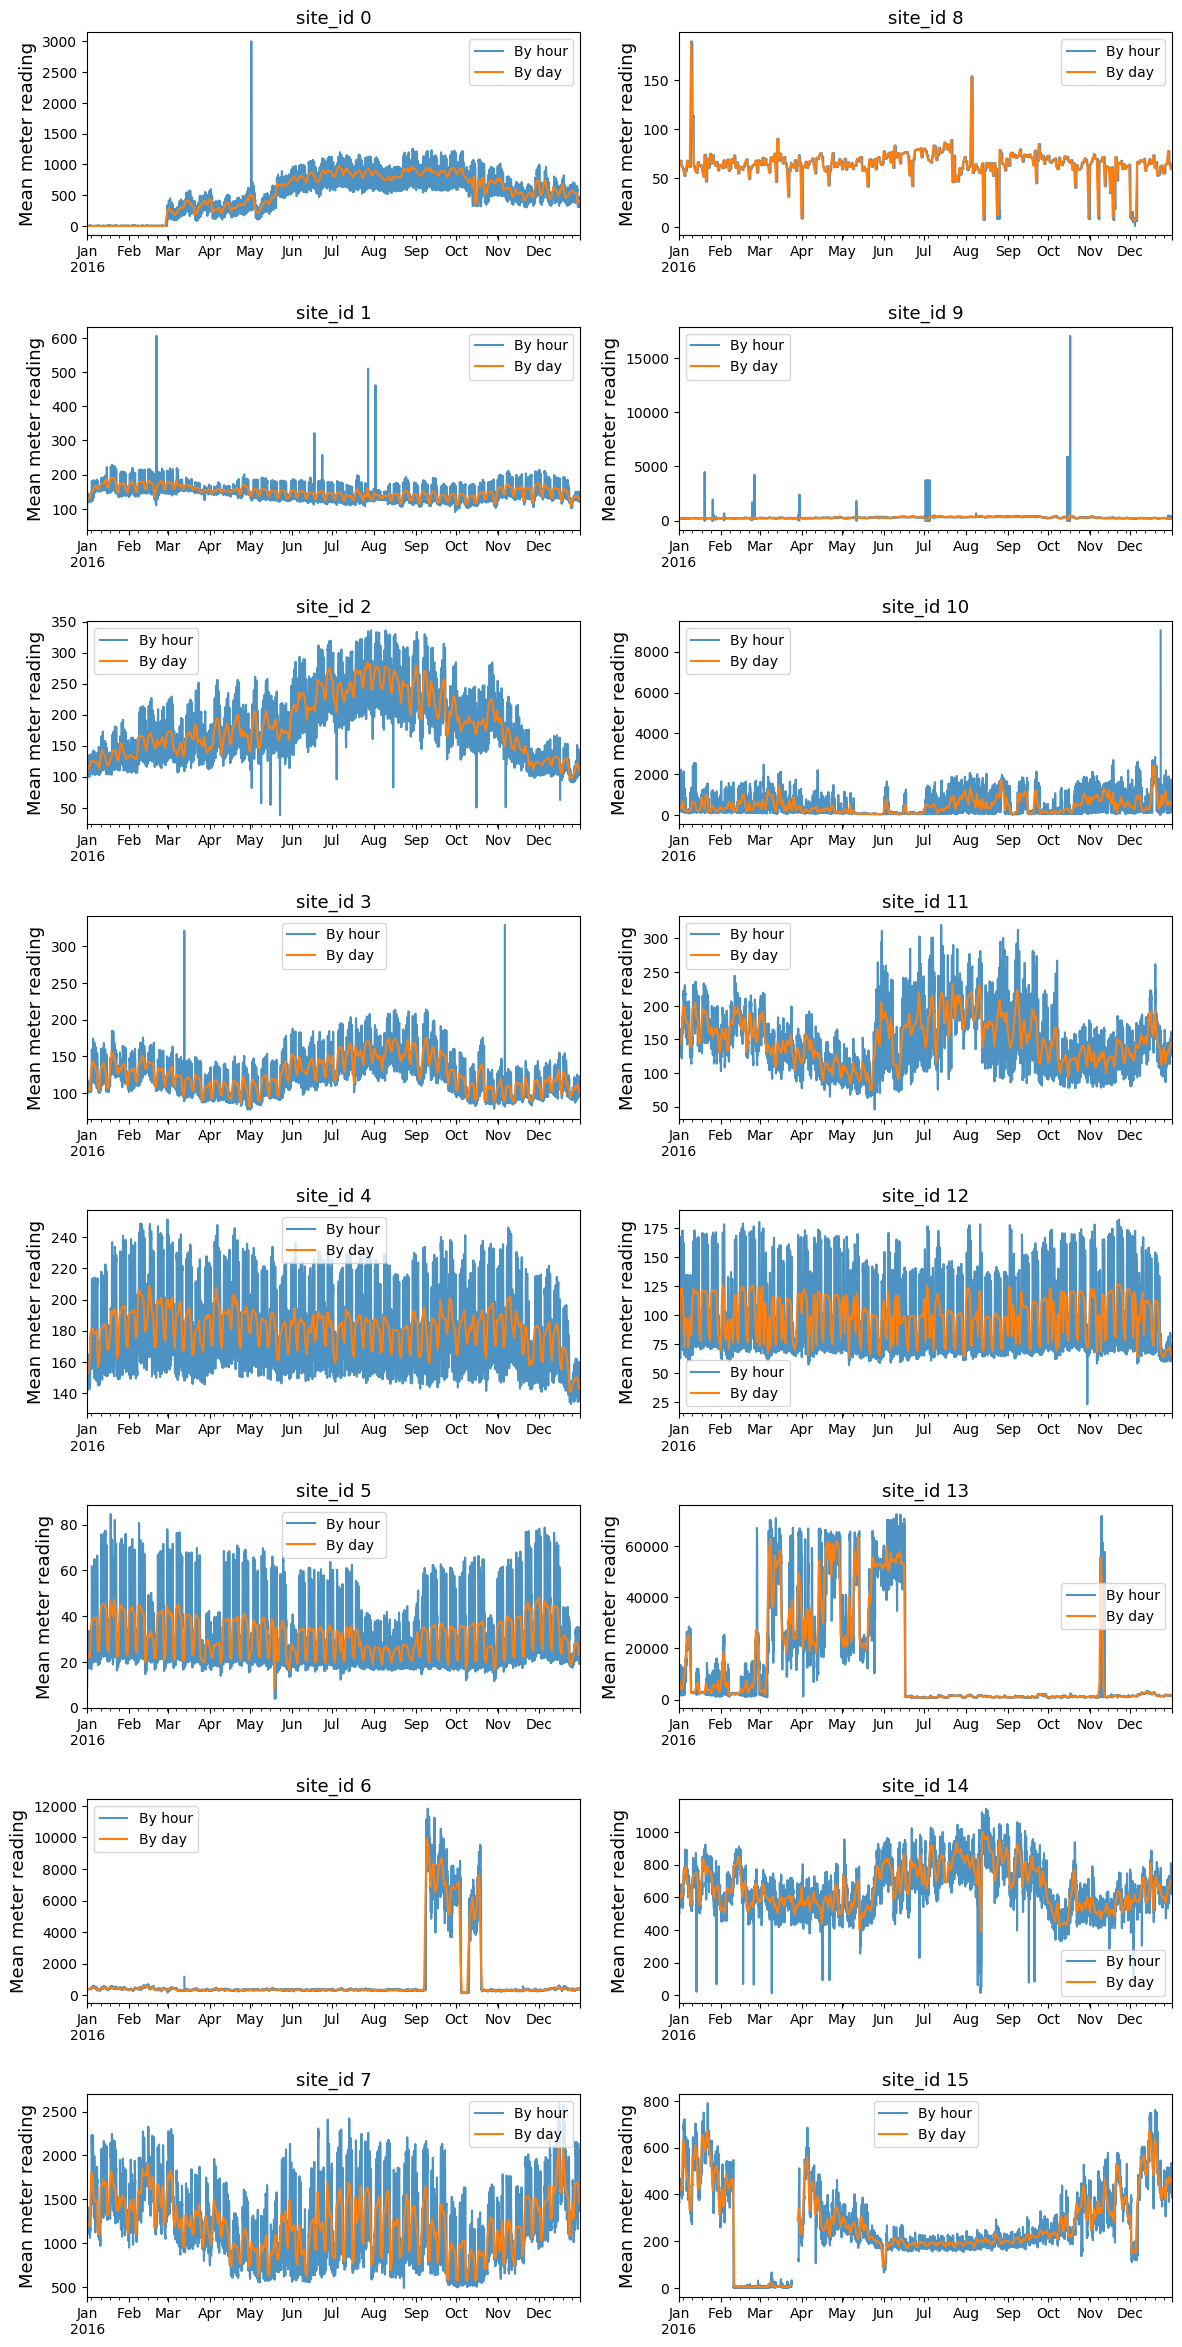

In [9]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)

for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

In [10]:
train.query('site_id == 13').groupby('building_id').mean().sort_values(by='meter_reading', ascending=False)
building['site_id'].value_counts()

3     274
13    154
2     135
15    124
9     124
0     105
14    102
4      91
5      89
8      70
1      51
6      44
12     36
10     30
7      15
11      5
Name: site_id, dtype: int64

In [11]:
train = train.query('building_id != 1099')

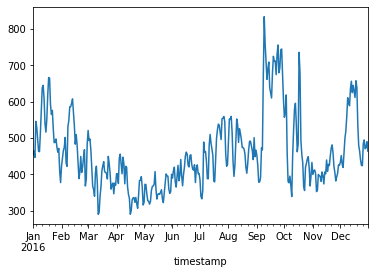

In [12]:
train.set_index('timestamp').resample('D')['meter_reading'].mean().plot()

In [13]:
train = train.query('site_id != 0')

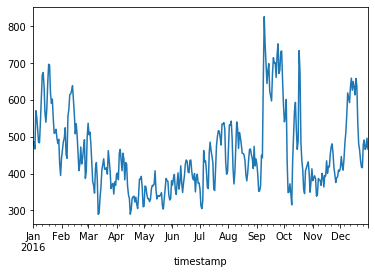

In [14]:
train.set_index('timestamp').resample('D')['meter_reading'].mean().plot()

In [15]:
train = train.query('building_id != 778')

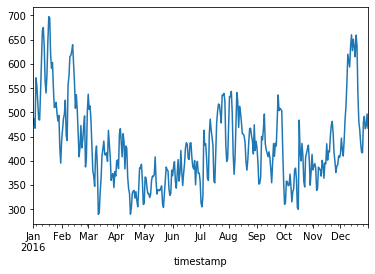

In [16]:
train.set_index('timestamp').resample('D')['meter_reading'].mean().plot();

### Feature Engineering

In [76]:
train['Hour'] = train.timestamp.dt.hour
train['Day'] = train.timestamp.dt.day
train['DOW'] = train.timestamp.dt.weekday
train['Day_Name'] = train.timestamp.dt.day_name()
train['Month'] = train.timestamp.dt.month_name()

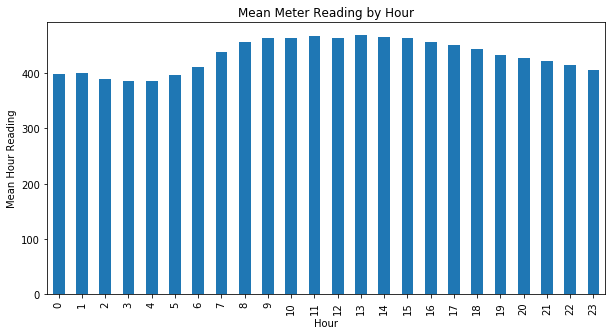

In [75]:
train.groupby('Hour')['meter_reading'].mean().head(24).plot(kind='bar', figsize=(10,5))
plt.ylabel('Mean Hour Reading')
plt.title('Mean Meter Reading by Hour');

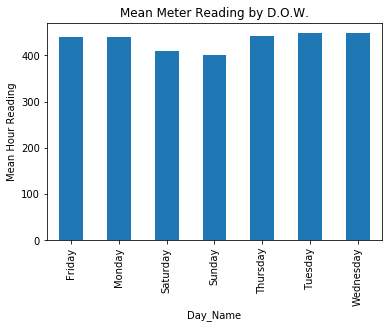

In [95]:
dayagg = train.groupby('Day_Name')['meter_reading'].mean().head(20).plot(kind='bar')
plt.ylabel('Mean Hour Reading')
plt.title('Mean Meter Reading by D.O.W.');

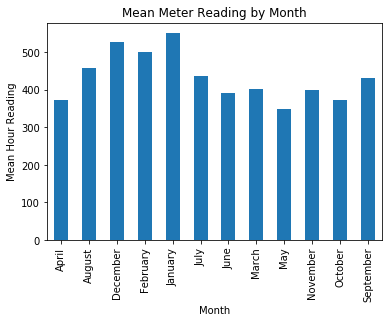

In [96]:
train.groupby('Month')['meter_reading'].mean().head(20).plot(kind='bar')
plt.ylabel('Mean Hour Reading')
plt.title('Mean Meter Reading by Month');

In [100]:
train = train.drop(columns = ['DOW','Day','log_meter_reading','sea_level_pressure','wind_direction'])